<td>
   <a target="_blank" href="https://labelbox.com" ><img src="https://labelbox.com/blog/content/images/2021/02/logo-v4.svg" width=256/></a>
</td>

<td>
<a href="https://colab.research.google.com/github/Labelbox/labelbox-python/blob/develop/examples/model_assisted_labeling/ner_mal.ipynb" target="_blank"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</td>

<td>
<a href="https://github.com/Labelbox/labelbox-python/tree/develop/examples/model_assisted_labeling/ner_mal.ipynb" target="_blank"><img
src="https://img.shields.io/badge/GitHub-100000?logo=github&logoColor=white" alt="GitHub"></a>
</td>

# Named Entity Recognition MAL
* Upload model inferences for NER tasks

In [1]:
!pip -q install labelbox flair wikipedia-api
# ** Install will take a while **

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.


In [2]:
from labelbox import Client
from labelbox.schema.ontology import OntologyBuilder, Tool
from labelbox import Project, Dataset, Client, LabelingFrontend
from typing import Dict, Any
from flair.models import SequenceTagger
from flair.data import Sentence
import wikipediaapi
import uuid
import requests
import ndjson
import os

# API Key and Client
Provide a valid api key below in order to properly connect to the Labelbox Client.

In [5]:
# Add your api key
API_KEY = None
client = Client(api_key=API_KEY)

### Project Setup
* We want to setup a task where we predict all org and person entities.
   - We also want a classification indicating that the mal upload was not confident.

In [6]:
# Setup the ontology.
ontology_builder = OntologyBuilder(tools=[
    Tool(tool=Tool.Type.NER, name="org"),
    Tool(tool=Tool.Type.NER, name="person"),
])

In [7]:
# Lets setup a project to label
# Note see Ontology, Project, and Project_setup notebooks for more information on this section.
wiki_wiki = wikipediaapi.Wikipedia('en')
page_py = wiki_wiki.page('Marketing')
project = client.create_project(name="ner_mal_project")
dataset = client.create_dataset(name="net_mal_dataset")
data_row = dataset.create_data_row(row_data=page_py.text)
editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == 'editor'))
project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

In [8]:
project.enable_model_assisted_labeling()

True

In [9]:
ontology = OntologyBuilder.from_project(project)
feature_schema_lookup = {
    tool.name: tool.feature_schema_id for tool in ontology.tools
}

### Load the model and predict

In [10]:
#Create model
model = SequenceTagger.load('ner-ontonotes-fast')
sentence = Sentence(page_py.text)
model.predict(sentence)
entities = sentence.to_dict(tag_type='ner')['entities']

2021-04-28 13:39:33,259 --------------------------------------------------------------------------------
2021-04-28 13:39:33,260 The model key 'ner-ontonotes-fast' now maps to 'https://huggingface.co/flair/ner-english-ontonotes-fast' on the HuggingFace ModelHub
2021-04-28 13:39:33,260  - The most current version of the model is automatically downloaded from there.
2021-04-28 13:39:33,261  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes-fast/en-ner-ontonotes-fast-v0.4.pt)
2021-04-28 13:39:33,262 --------------------------------------------------------------------------------
2021-04-28 13:39:33,785 loading file /Users/matthewsokoloff/.flair/models/ner-english-ontonotes-fast/0d55dd3b912da9cf26e003035a0c269a0e9ab222f0be1e48a3bbba3a58c0fed0.c9907cd5fde3ce84b71a4172e7ca03841cd81ab71d13eb68aa08b259f57c00b6


### Create ndjson

In [11]:
def get_ner_ndjson(datarow_id: str, feature_schema_id: str, start: int,
                   end: int) -> Dict[str, Any]:
    """
    * https://docs.labelbox.com/data-model/en/index-en#entity
    
    Args:
        datarow_id (str): id of the data_row (in this case image) to add this annotation to
        feature_schema_id (str): id of the bbox tool in the current ontology
        start (int): Character index where the entity begins
        end (int): Character index where the entity ends
    Returns:
        ndjson representation of a named entity
    """
    return {
        "uuid": str(uuid.uuid4()),
        "schemaId": feature_schema_id,
        "dataRow": {
            "id": datarow_id
        },
        "location": {
            "start": start,
            "end": end
        }
    }

In [12]:
ndjsons = []
for entity in entities:
    pred = entity["labels"][0].value.lower()
    if pred not in ["org", "person"]:
        continue

    start = entity["start_pos"]
    end = entity["end_pos"]
    ndjsons.append(
        get_ner_ndjson(data_row.uid, feature_schema_lookup[pred], start, end))

### Upload

In [13]:
upload_task = project.upload_annotations(name=f"upload-job-{uuid.uuid4()}",
                                         annotations=ndjsons,
                                         validate=True)

In [14]:
#Wait for upload to finish
upload_task.wait_until_done()
#Review the upload status
print(upload_task.errors)

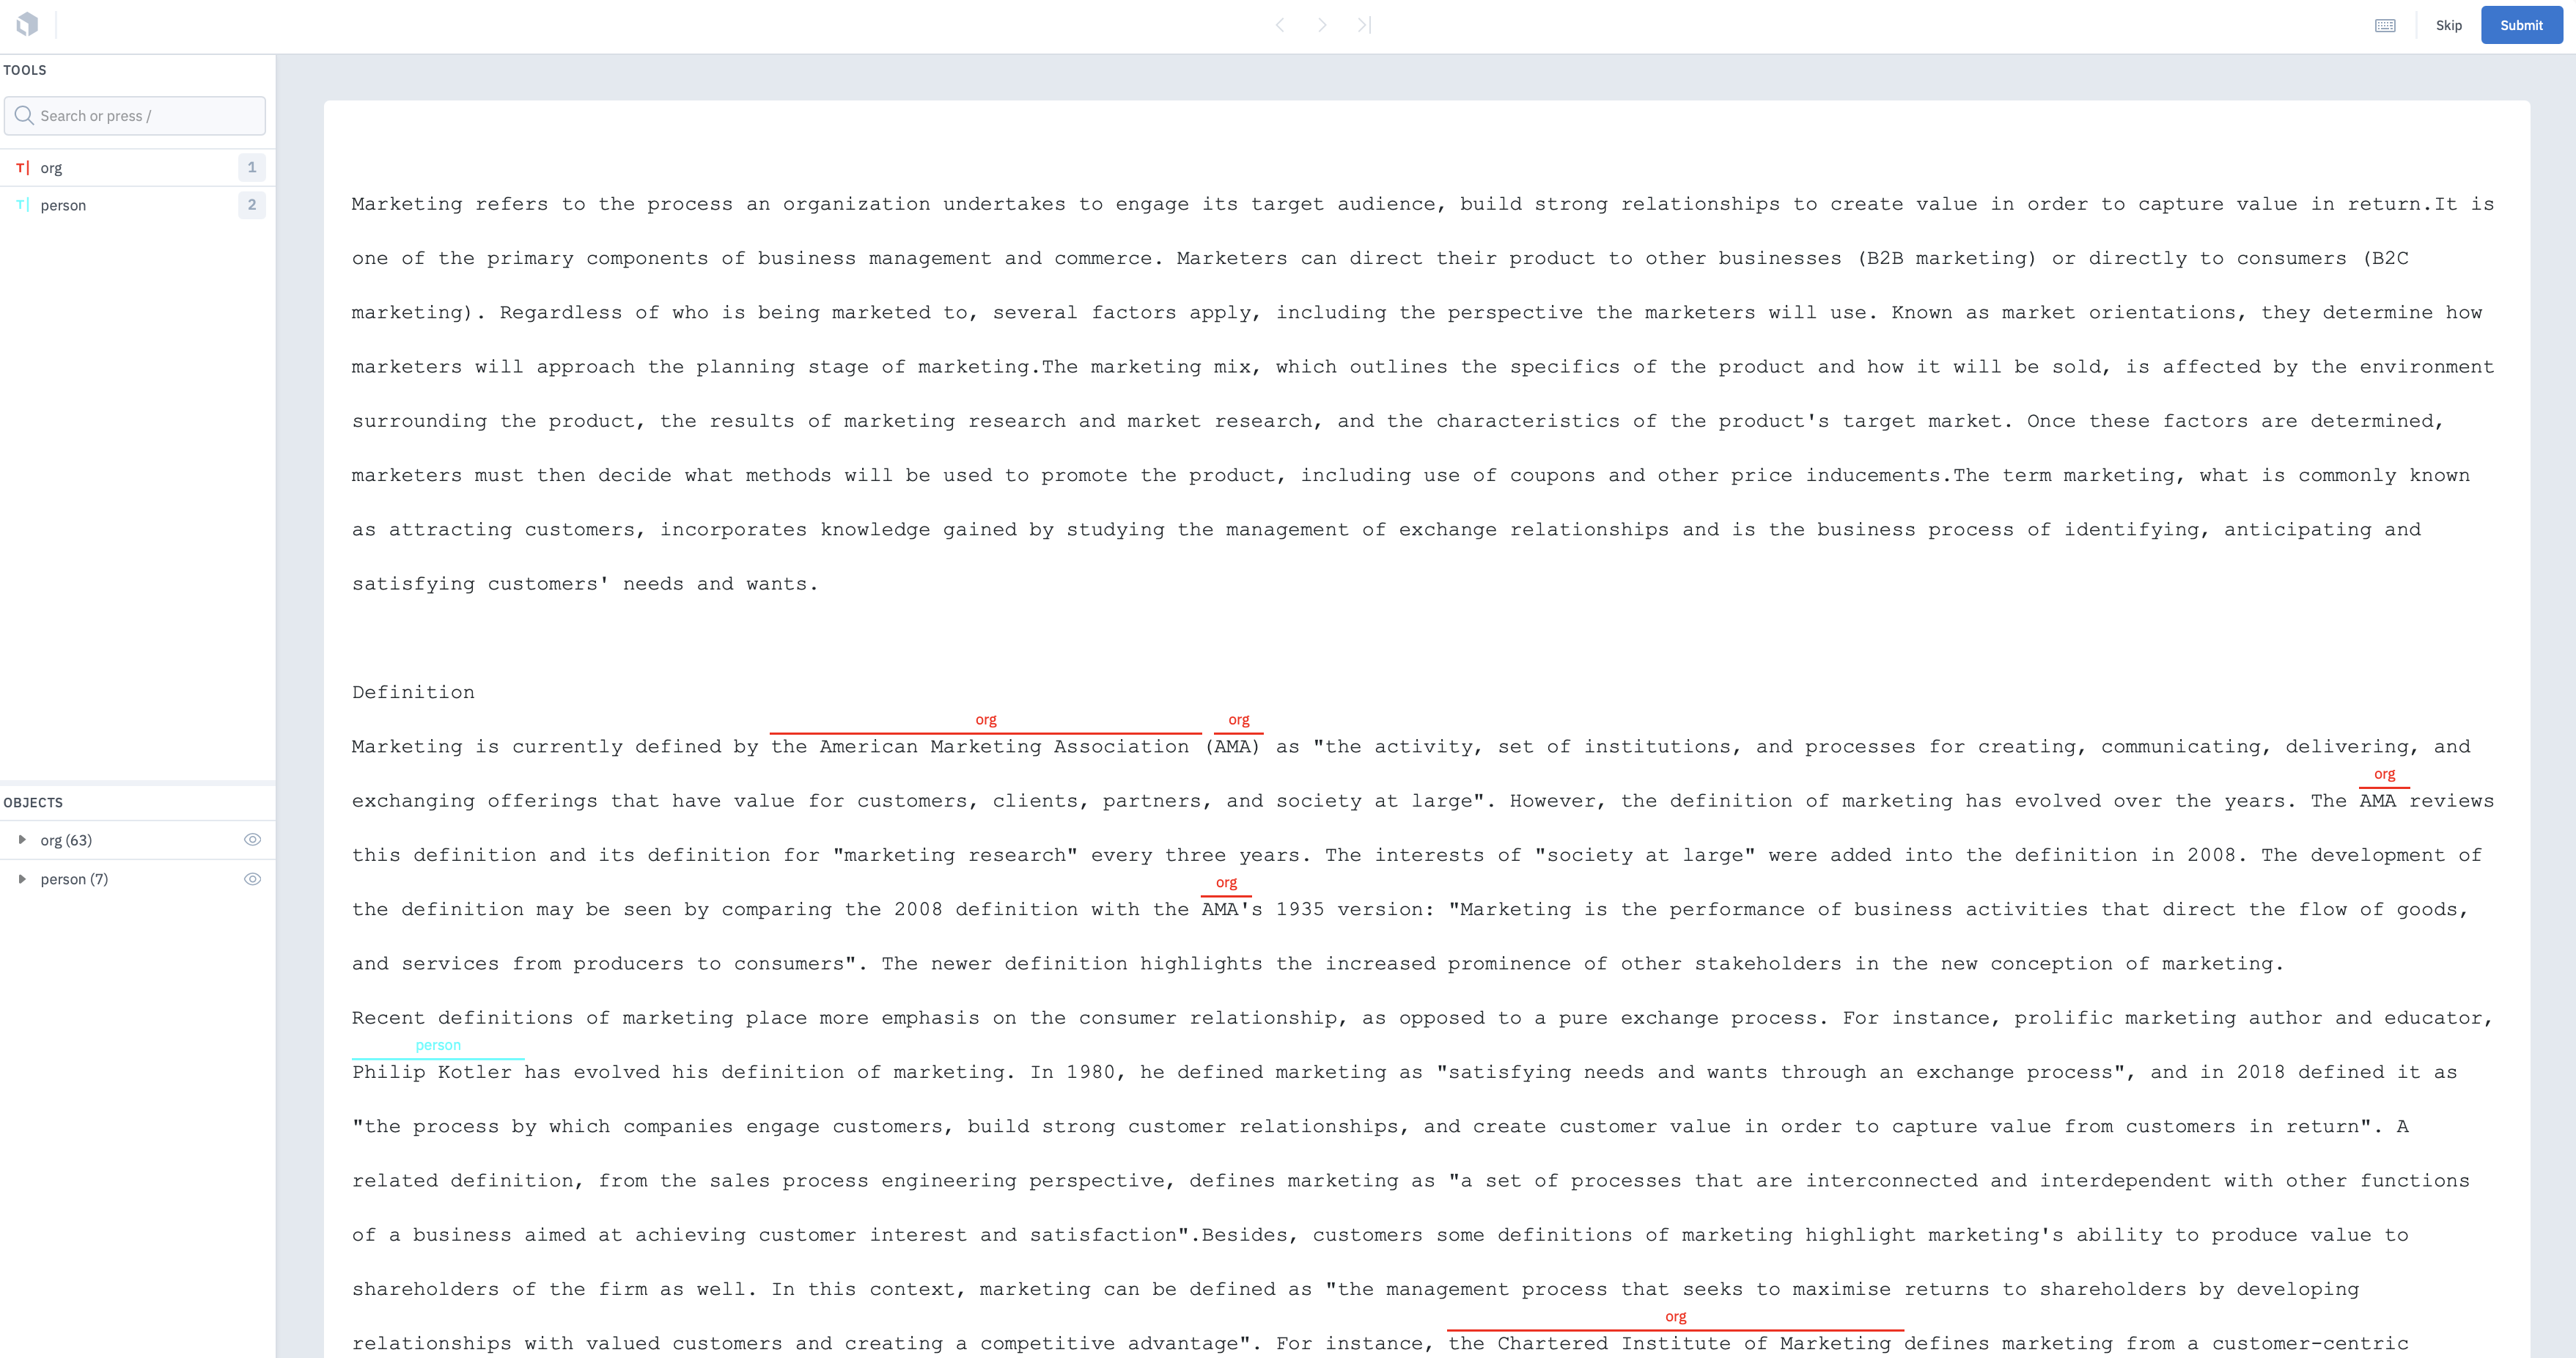